DS 3000

# Team 39: Predicting Trending Fashion Videos through TikTok

## Bayden Ibrahim, Kush Raimalani, Anjali Tanna, and Xinwen Zhang

In [1]:
# Extraction
import pandas as pd

df = pd.read_json('NEWTTDATA.json')
df.head()

,statusCode,itemList,cursor,hasMore
0,0,"{'id': '7004421700007841030', 'desc': 'Septemb...",1860,True
1,0,"{'id': '7058583535610809605', 'desc': 'je fais...",1860,True
2,0,"{'id': '6988932280295230725', 'desc': 'trends ...",1860,True
3,0,"{'id': '6993764316159741190', 'desc': 'gimme g...",1860,True
4,0,"{'id': '6977481930044493061', 'desc': 'Reply t...",1860,True


In [30]:
# Transformation and Loading

# list of trending videos 
trending_videos = df['itemList']

# initialize dataframe
df_tiktok = pd.DataFrame()

for vid_idx in range(1917): 
    vid = trending_videos[vid_idx]
    s_tiktok = pd.Series()
    
    # unique video id
    s_tiktok['vidId'] = [vid['id']][0]
    
    # video caption
    s_tiktok['caption'] = [vid['desc']][0]
     
    # video hashtags
    # if the video has hashtags
    if 'textExtra' in vid.keys():
        # initialize list to store hashtags
        hashtag_list = []
        for idx in range(len(vid['textExtra'])):
            hashtag = vid['textExtra'][idx]['hashtagName']
            # if hashtag is not empty string
            if hashtag != '':
                hashtag_list.append(hashtag)
        # store hashtags into dataframe
        s_tiktok['hashtag'] = hashtag_list
        s_tiktok['numHashtag'] = len(hashtag_list)
    
    
    # video duration in seconds
    s_tiktok['duration (s)'] = [vid['video']['duration']][0]
    
    # creator id, username, verification status, private account
    s_tiktok['authorId'] = vid['author']['id']
    s_tiktok['uniqueId'] = vid['author']['uniqueId']
    s_tiktok['verified'] = vid['author']['verified']
    s_tiktok['privateAccount'] = vid['author']['privateAccount']
    
    # music id, music title
    s_tiktok['musicId'] = vid['music']['id']
    s_tiktok['musicTitle'] = vid['music']['title']
    
    # like, share, comment, play
    s_tiktok['likeCount'] = vid['stats']['diggCount']
    s_tiktok['shareCount'] = vid['stats']['shareCount']
    s_tiktok['commentCount'] = vid['stats']['commentCount']
    s_tiktok['playCount'] = vid['stats']['playCount']
    
    # creator following, follower, number of posts
    s_tiktok['followingCount'] = vid['authorStats']['followingCount']
    s_tiktok['followerCount'] = vid['authorStats']['followerCount']
    s_tiktok['videoCount'] = vid['authorStats']['videoCount']
    
    # is this video an ad
    s_tiktok['isAd'] = vid['isAd']
    
    df_tiktok = df_tiktok.append(s_tiktok, ignore_index = True)
    
# some features that are false are showing as 0.0, and true as 1.0
# make everything uniform -- only showing as True or False
df_tiktok['verified']= df_tiktok['verified'].apply(lambda x: True if x == 1.0 else x)
df_tiktok['privateAccount']= df_tiktok['privateAccount'].apply(lambda x: False if x == 0.0 else x)
df_tiktok['isAd']= df_tiktok['isAd'].apply(lambda x: False if x == 0.0 else x)

/var/folders/3x/09qtw5n97t7cddrhx1vknvfw0000gn/T/ipykernel_22335/3430201921.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_tiktok = pd.Series()


In [31]:
df_tiktok.head()

,vidId,caption,hashtag,numHashtag,duration (s),authorId,uniqueId,verified,privateAccount,musicId,musicTitle,likeCount,shareCount,commentCount,playCount,followingCount,followerCount,videoCount,isAd
0,7004421700007841030,September must have!!! PART 1🤎 #fashionhacks #...,"[fashionhacks, fashiontrends]",2.0,31.0,6563206248362999813,_emmaaasss,0.0,False,6709415906423867393,Sex and the City (Main Theme),12200.0,24.0,38.0,68300.0,831.0,222600.0,858.0,False
1,7058583535610809605,je fais quelle couleur ensuite guys ? 💖😘 @clai...,"[@clairelatour, tiktokfashion, mode, conseilsm...",6.0,14.0,6647813383222394885,clairelatour,False,False,6863118485925398530,Baby Work It,6123.0,9.0,60.0,57100.0,403.0,391600.0,896.0,False
2,6988932280295230725,trends to invest in…because they’ll be here fo...,"[fashiontrends, fashiontrends2021, 2022fashion...",4.0,10.0,6714077600156828678,rachelnoelleclark,False,False,6979312907339254533,son original,6032.0,116.0,16.0,59700.0,225.0,202600.0,603.0,False
3,6993764316159741190,gimme gogo boots and opera gloves I’ll be a ha...,"[falltrends2021, fashiontrends2021, fashiontre...",3.0,46.0,6914500399362458630,taylortiminskas,False,False,6789995456064669697,Juless Edits,6026.0,53.0,36.0,39100.0,38.0,163100.0,478.0,False
4,6977481930044493061,Reply to @itsveronicaustin Club Kid fashion de...,"[clubkid, fashiontrends, trendcycle, fashioncy...",4.0,27.0,6817993576023983109,oldloserinbrooklyn,True,False,96226181,Vogue,6001.0,66.0,62.0,36300.0,552.0,327900.0,431.0,False


## Machine Learning

In [46]:
x_feat_list = ['numHashtag', 'duration (s)', 'verified', 'followingCount', 'followerCount', 'videoCount', 
              'likeCount', 'shareCount', 'commentCount']

df_tiktok_scaled = pd.DataFrame()
for feat in x_feat_list: 
    df_tiktok_scaled[f'{feat}_scaled'] = df_tiktok[feat] / df_tiktok[feat].std()
    
df_tiktok_scaled['playCount'] = df_tiktok['playCount']

In [47]:
df_tiktok_scaled.head()

,numHashtag_scaled,duration (s)_scaled,verified_scaled,followingCount_scaled,followerCount_scaled,videoCount_scaled,likeCount_scaled,shareCount_scaled,commentCount_scaled,playCount
0,0.619664,1.443591,0.0,1.465507,0.292550,1.290296,0.068658,0.016396,0.039274,68300.0
1,1.858991,0.651944,0.0,0.710709,0.514657,1.347441,0.034459,0.006149,0.062011,57100.0
2,1.239327,0.465674,0.0,0.396798,0.266265,0.906816,0.033946,0.079249,0.016536,59700.0
3,0.929496,2.142102,0.0,0.067015,0.214353,0.718836,0.033913,0.036208,0.037207,39100.0
4,1.239327,1.257321,3.614622,0.973477,0.430940,0.648155,0.033772,0.045090,0.064078,36300.0


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# features to train on / predict
x_feat_list = ['numHashtag_scaled', 'duration (s)_scaled', 'verified_scaled', 'followingCount_scaled',
               'followerCount_scaled', 'videoCount_scaled']
y_feat = 'playCount'

# extract features to train on / predict
x = df_tiktok_scaled.loc[:, x_feat_list].values
y_true = df_tiktok_scaled.loc[:, y_feat].values

# initialize a random forest regressor
rf_reg = RandomForestRegressor()

# set number of folds
n_splits = 5

# cross validation
skfold = StratifiedKFold(n_splits=n_splits)

# store predicted values
y_pred = np.empty_like(y_true)

for train_idx, test_idx in skfold.split(x, y_true):
    # index to split training / test data
    x_train = x[train_idx, :]
    x_test = x[test_idx, :]
    y_true_train = y_true[train_idx]

    # fit regressor to data
    rf_reg = rf_reg.fit(x_train, y_true_train)

    # estimate each property's price
    y_pred[test_idx] = rf_reg.predict(x_test)
    
# cross validated R2 score
r2_score(y_true=y_true, y_pred=y_pred)

/Users/xinwenzhang/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.7774102449574185

In [35]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(Mean decrease in MSE across all Random Forest Regressors)')

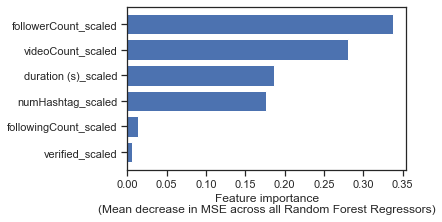

In [45]:
# plot the feature importances
plot_feat_import(x_feat_list, rf_reg.feature_importances_)

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# features to train on / predict
x_feat_list = ['likeCount_scaled', 'shareCount_scaled', 'commentCount_scaled']
y_feat = 'playCount'

# extract features to train on / predict
x = df_tiktok_scaled.loc[:, x_feat_list].values
y_true = df_tiktok_scaled.loc[:, y_feat].values

# initialize a random forest regressor
rf_reg = RandomForestRegressor()

# set number of folds
n_splits = 3

# cross validation
skfold = StratifiedKFold(n_splits=n_splits)

# store predicted values
y_pred = np.empty_like(y_true)

for train_idx, test_idx in skfold.split(x, y_true):
    # index to split training / test data
    x_train = x[train_idx, :]
    x_test = x[test_idx, :]
    y_true_train = y_true[train_idx]

    # fit regressor to data
    rf_reg = rf_reg.fit(x_train, y_true_train)

    # estimate each property's price
    y_pred[test_idx] = rf_reg.predict(x_test)
    
# cross validated R2 score
r2_score(y_true=y_true, y_pred=y_pred)

/Users/xinwenzhang/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0.868479639460618

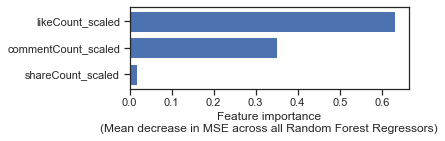

In [50]:
plot_feat_import(x_feat_list, rf_reg.feature_importances_)